In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!ls /content/drive/MyDrive/ndui

In [ ]:
import xarray as xr
import numpy as np
ds_dmsp = xr.open_dataset('/content/drive/MyDrive/ndui/dmsp_2012_austin.nc').constant
ds_viirs = xr.open_dataset('/content/drive/MyDrive/ndui/viirs_2012_austin.nc').avg_rad

In [ ]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)

In [ ]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

In [ ]:
# Create patches from the image
patch_size = 32
img = x_train[:576,:576]
patches = patchify(img, patch_size)

In [ ]:
x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:576,:576], patch_size)
y_train_patches = patchify(y_train[:576,:576], patch_size)
x_train_patches.shape

(324, 32, 32)

In [ ]:
x_val_patches = x_train_patches[200:300]
y_val_patches = y_train_patches[200:300]

x_test_patches = x_train_patches[300:]
y_test_patches = y_train_patches[300:]

x_train_patches = x_train_patches[:200]
y_train_patches = y_train_patches[:200]

In [ ]:
x_test_patches.shape

(24, 32, 32)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

In [ ]:
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [ ]:
lr, hr = train_dataset.__getitem__(0)
print(lr.shape, hr.shape, train_dataset.__len__())

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) 200


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [ ]:
for batch in train_dataloader:
    data, targets = batch
    print(data.size())  # Should print torch.Size([16, 1, 30, 30])
    print(targets.size())  # Should print torch.Size([16, 1, 30, 601])
    break

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])


In [ ]:
import torch
from diffusers import UNet2DModel, EDMEulerScheduler
from torch.optim import Adam
from tqdm import tqdm
# from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)


# model = UNet2DModel(
#         sample_size=32,           # the target image resolution
#         in_channels=1 + class_emb_size, # Additional input channels for class cond.
#         out_channels=1,           # the number of output channels
#         layers_per_block=2,       # how many ResNet layers to use per UNet block
#         block_out_channels=(32, 64, 64),
#         down_block_types=(
#             "DownBlock2D",        # a regular ResNet downsampling block
#             "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
#             "AttnDownBlock2D",
#         ),
#         up_block_types=(
#             "AttnUpBlock2D",
#             "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
#             "UpBlock2D",          # a regular ResNet upsampling block
#           ),
#     ).to(device)

In [ ]:
!pip install wandb

# DDPM

In [ ]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="ddpm", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?
n_epochs =5000


# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Streaming output truncated to the last 5000 lines.
Epoch 2500: Avg Train Loss: 0.000828, Avg Val Loss: 0.072452
Early stopping patience: 501/5000
Epoch 2501: Avg Train Loss: 0.000640, Avg Val Loss: 0.029370
Early stopping patience: 502/5000
Epoch 2502: Avg Train Loss: 0.001307, Avg Val Loss: 0.056230
Early stopping patience: 503/5000
Epoch 2503: Avg Train Loss: 0.000650, Avg Val Loss: 0.038832
Early stopping patience: 504/5000
Epoch 2504: Avg Train Loss: 0.001063, Avg Val Loss: 0.059629
Early stopping patience: 505/5000
Epoch 2505: Avg Train Loss: 0.002683, Avg Val Loss: 0.035280
Early stopping patience: 506/5000
Epoch 2506: Avg Train Loss: 0.000445, Avg Val Loss: 0.030602
Early stopping patience: 507/5000
Epoch 2507: Avg Train Loss: 0.000541, Avg Val Loss: 0.043953
Early stopping patience: 508/5000
Epoch 2508: Avg Train Loss: 0.001136, Avg Val Loss: 0.057582
Early stopping patience: 509/5000
Epoch 2509: Avg Train Loss: 0.000702, Avg Val Loss: 0.051548
Early stopping patience: 510/5000

In [ ]:
# Load the trained model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

for batch in test_dataloader:
    lr, hr = batch
    lr, hr = lr.to(device), hr.to(device)
    noise = torch.randn_like(hr)
    pred = noise.clone()
    net_input = torch.cat((noise, lr), 1)
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

        # Get model pred
        with torch.no_grad():
            residual = model(net_input, t).sample  # Extract .sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample  # Correct attribute usage
        net_input = torch.cat((pred, lr), 1)

<ipython-input-23-986cc1987f4f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:512,:512]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)

pred_patches = []
for batch in x_train_patches_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)

    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(512, 512)

In [ ]:
lats = ds_dmsp.y.values[:512]
lons = ds_dmsp.x.values[:512]
dmsp_ = ds_dmsp.values[0,:512,:512]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:512,:512],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

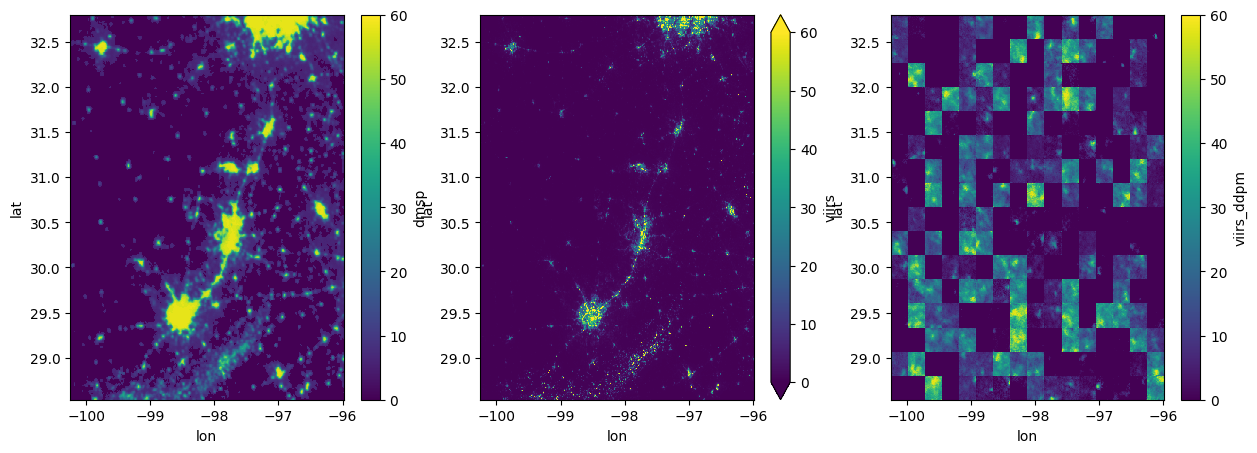

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# Without Patches

In [ ]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

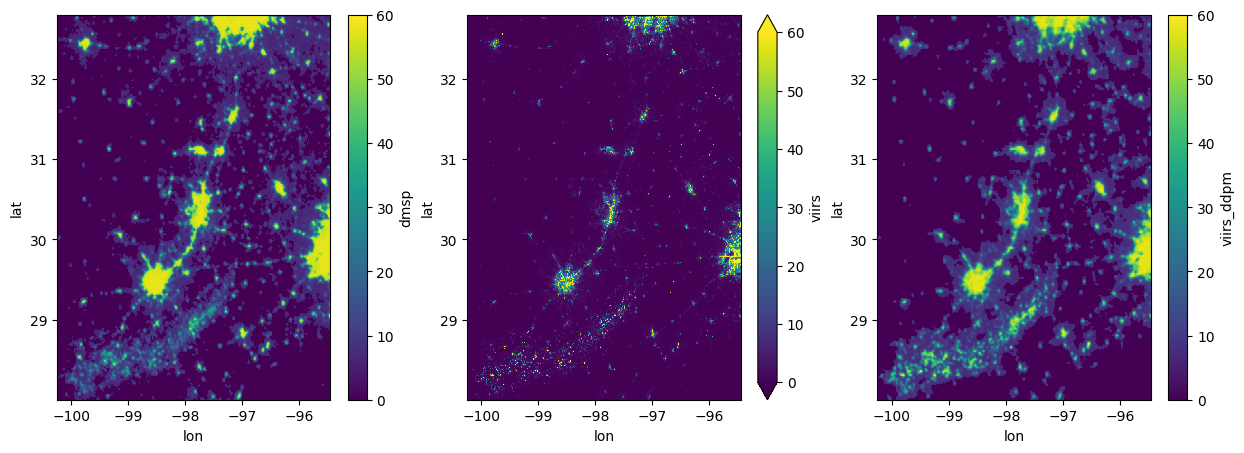

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# DDIM Diffusion

In [ ]:
from diffusers import DDIMScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = DDIMScheduler(rescale_betas_zero_snr=True)

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="ddim", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?
n_epochs =5000


# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Streaming output truncated to the last 5000 lines.
Epoch 633: Avg Train Loss: 0.006629, Avg Val Loss: 0.019109
Early stopping patience: 284/5000
Epoch 634: Avg Train Loss: 0.002868, Avg Val Loss: 0.016301
Early stopping patience: 285/5000
Epoch 635: Avg Train Loss: 0.004917, Avg Val Loss: 0.023356
Early stopping patience: 286/5000
Epoch 636: Avg Train Loss: 0.007065, Avg Val Loss: 0.007193
Early stopping patience: 287/5000
Epoch 637: Avg Train Loss: 0.005715, Avg Val Loss: 0.010472
Early stopping patience: 288/5000
Epoch 638: Avg Train Loss: 0.003972, Avg Val Loss: 0.012399
Early stopping patience: 289/5000
Epoch 639: Avg Train Loss: 0.004245, Avg Val Loss: 0.008102
Early stopping patience: 290/5000
Epoch 640: Avg Train Loss: 0.003332, Avg Val Loss: 0.012072
Early stopping patience: 291/5000
Epoch 641: Avg Train Loss: 0.004867, Avg Val Loss: 0.014087
Early stopping patience: 292/5000
Epoch 642: Avg Train Loss: 0.006605, Avg Val Loss: 0.006924
Early stopping patience: 293/5000
Epoch 643

KeyboardInterrupt: 

In [ ]:
model.eval()
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps: 100%|██████████| 50/50 [26:03<00:00, 31.28s/it]


In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddim': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

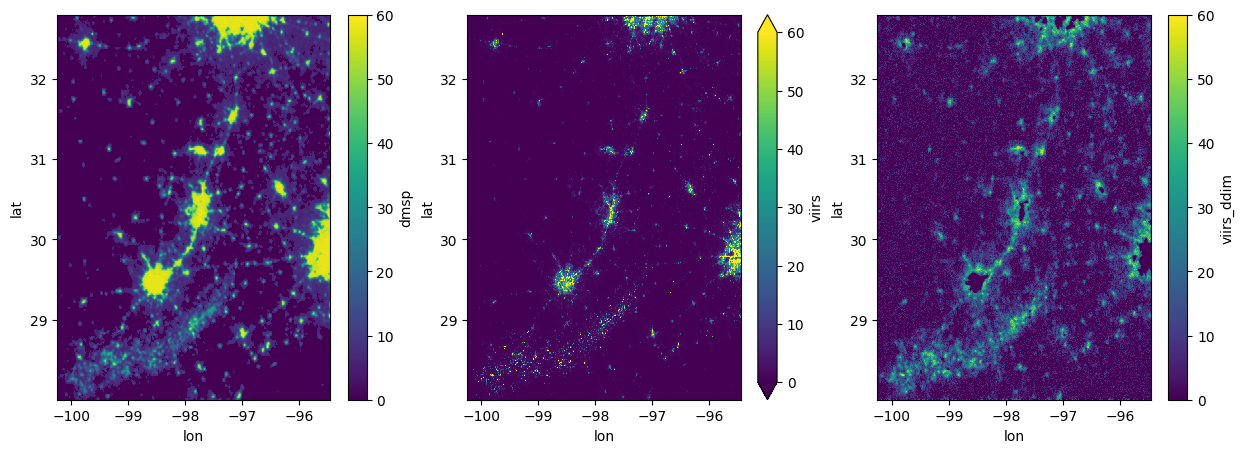

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddim.plot(ax=ax[2], vmax=60)

# DEISMultistepScheduler

In [ ]:
from diffusers import DEISMultistepScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = DEISMultistepScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="ddiminverse", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 25

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.144846, Avg Val Loss: 0.119766
Saved best model!
Epoch 1: Avg Train Loss: 0.075171, Avg Val Loss: 0.052803
Saved best model!
Epoch 2: Avg Train Loss: 0.028278, Avg Val Loss: 0.019114
Saved best model!
Epoch 3: Avg Train Loss: 0.025688, Avg Val Loss: 0.012029
Saved best model!
Epoch 4: Avg Train Loss: 0.015019, Avg Val Loss: 0.031413
Early stopping patience: 1/5000
Epoch 5: Avg Train Loss: 0.010286, Avg Val Loss: 0.028338
Early stopping patience: 2/5000
Epoch 6: Avg Train Loss: 0.010744, Avg Val Loss: 0.026290
Early stopping patience: 3/5000
Epoch 7: Avg Train Loss: 0.010752, Avg Val Loss: 0.006778
Saved best model!
Epoch 8: Avg Train Loss: 0.008801, Avg Val Loss: 0.038314
Early stopping patience: 1/5000
Epoch 9: Avg Train Loss: 0.011344, Avg Val Loss: 0.026878
Early stopping patience: 2/5000
Epoch 10: Avg Train Loss: 0.008954, Avg Val Loss: 0.021271
Early stopping patience: 3/5000
Epoch 11: Avg Train Loss: 0.008210, Avg Val Loss: 0.009046
Early stopping patie

In [ ]:
model.eval()
num_inference_steps = 10
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps: 100%|██████████| 10/10 [04:44<00:00, 28.50s/it]


In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_deis': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

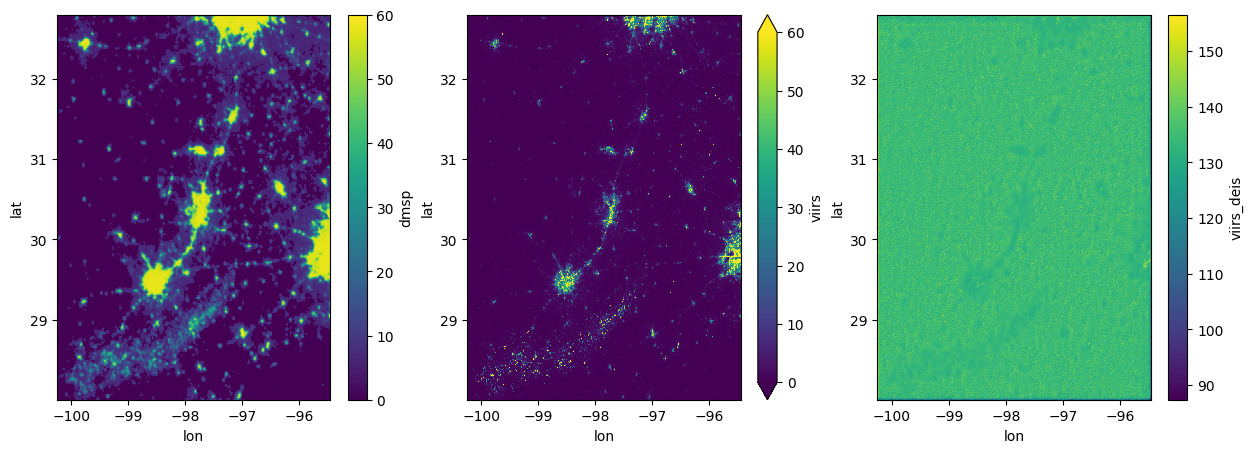

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_deis.plot(ax=ax[2])

# DPMSolverMultistepInverse

In [ ]:
from diffusers import DPMSolverMultistepScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = DPMSolverMultistepScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="DPMSolverMultistepScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?


n_epochs =5000
n_epochs = 25

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.423063, Avg Val Loss: 0.117234
Saved best model!
Epoch 1: Avg Train Loss: 0.100549, Avg Val Loss: 0.075928
Saved best model!
Epoch 2: Avg Train Loss: 0.063811, Avg Val Loss: 0.084810
Early stopping patience: 1/5000
Epoch 3: Avg Train Loss: 0.062080, Avg Val Loss: 0.066696
Saved best model!
Epoch 4: Avg Train Loss: 0.052389, Avg Val Loss: 0.038834
Saved best model!
Epoch 5: Avg Train Loss: 0.042298, Avg Val Loss: 0.045145
Early stopping patience: 1/5000
Epoch 6: Avg Train Loss: 0.032781, Avg Val Loss: 0.045179
Early stopping patience: 2/5000
Epoch 7: Avg Train Loss: 0.033000, Avg Val Loss: 0.031936
Saved best model!
Epoch 8: Avg Train Loss: 0.032668, Avg Val Loss: 0.028324
Saved best model!
Epoch 9: Avg Train Loss: 0.024964, Avg Val Loss: 0.023408
Saved best model!
Epoch 10: Avg Train Loss: 0.022536, Avg Val Loss: 0.033359
Early stopping patience: 1/5000
Epoch 11: Avg Train Loss: 0.027440, Avg Val Loss: 0.022384
Saved best model!
Epoch 12: Avg Train Loss: 0.02

In [ ]:
model.eval()
num_inference_steps = 10
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps: 100%|██████████| 10/10 [04:38<00:00, 27.87s/it]


In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_dpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

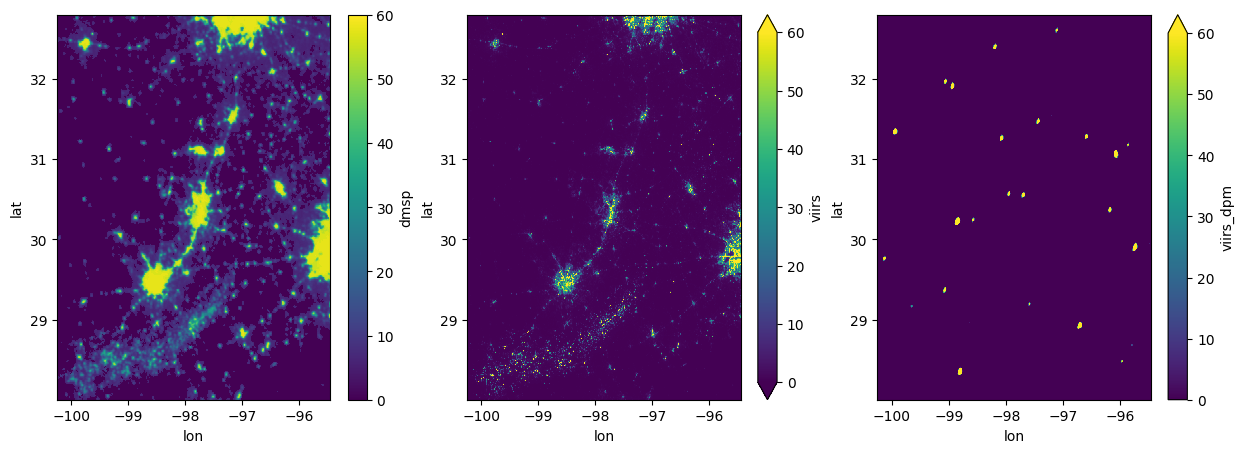

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_dpm.plot(ax=ax[2], vmax=60)

# DPMSolverSinglestepScheduler

In [ ]:
from diffusers import DPMSolverSinglestepScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = DPMSolverSinglestepScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="DPMSolverSinglestepScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 1000

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.448485, Avg Val Loss: 0.173882
Saved best model!
Epoch 1: Avg Train Loss: 0.139760, Avg Val Loss: 0.124967
Saved best model!
Epoch 2: Avg Train Loss: 0.105487, Avg Val Loss: 0.105901
Saved best model!
Epoch 3: Avg Train Loss: 0.090709, Avg Val Loss: 0.094108
Saved best model!
Epoch 4: Avg Train Loss: 0.079718, Avg Val Loss: 0.083297
Saved best model!
Epoch 5: Avg Train Loss: 0.071058, Avg Val Loss: 0.078174
Saved best model!
Epoch 6: Avg Train Loss: 0.065348, Avg Val Loss: 0.072655
Saved best model!
Epoch 7: Avg Train Loss: 0.060581, Avg Val Loss: 0.069605
Saved best model!
Epoch 8: Avg Train Loss: 0.057981, Avg Val Loss: 0.065661
Saved best model!
Epoch 9: Avg Train Loss: 0.056069, Avg Val Loss: 0.064966
Saved best model!
Epoch 10: Avg Train Loss: 0.053873, Avg Val Loss: 0.063813
Saved best model!
Epoch 11: Avg Train Loss: 0.052974, Avg Val Loss: 0.060524
Saved best model!
Epoch 12: Avg Train Loss: 0.051192, Avg Val Loss: 0.059865
Saved best model!
Epoch 13:

In [ ]:
model.eval()
num_inference_steps = 20
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

 `last_sigmas_type='zero'` is not supported for `lower_order_final=False`. Changing scheduler {self.config} to have `lower_order_final` set to True.


torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_dpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

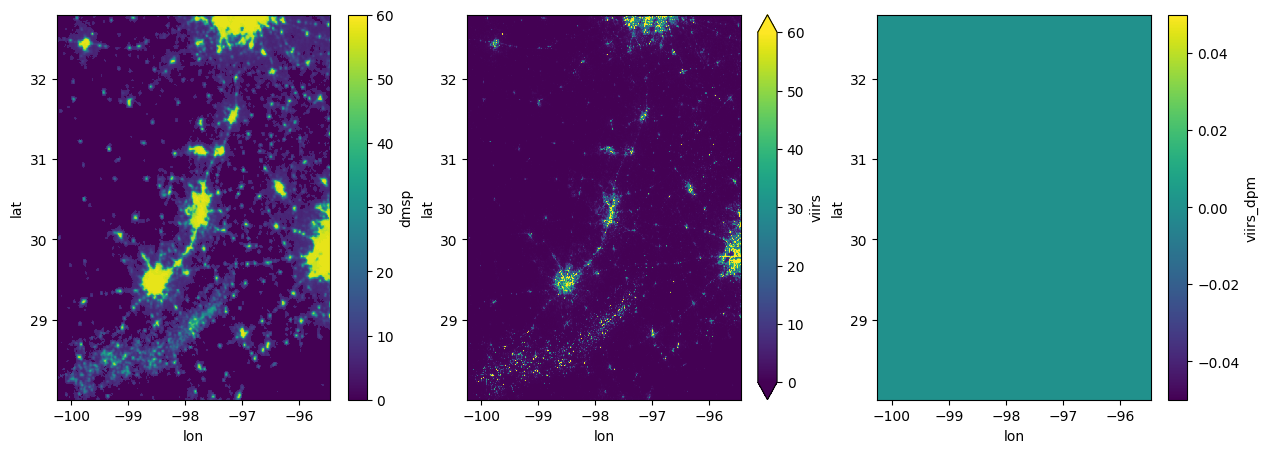

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_dpm.plot(ax=ax[2])

# EDMDPMSolverMultistepScheduler

In [ ]:
from diffusers import EDMDPMSolverMultistepScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = EDMDPMSolverMultistepScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="EDMDPMSolverMultistepScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 1000

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 1.033217, Avg Val Loss: 1.002802
Saved best model!
Epoch 1: Avg Train Loss: 0.970072, Avg Val Loss: 0.978455
Saved best model!
Epoch 2: Avg Train Loss: 0.929993, Avg Val Loss: 0.952660
Saved best model!
Epoch 3: Avg Train Loss: 0.883403, Avg Val Loss: 0.913049
Saved best model!
Epoch 4: Avg Train Loss: 0.815297, Avg Val Loss: 0.838126
Saved best model!
Epoch 5: Avg Train Loss: 0.733315, Avg Val Loss: 0.767134
Saved best model!
Epoch 6: Avg Train Loss: 0.679343, Avg Val Loss: 0.728253
Saved best model!
Epoch 7: Avg Train Loss: 0.639707, Avg Val Loss: 0.706415
Saved best model!
Epoch 8: Avg Train Loss: 0.621763, Avg Val Loss: 0.674358
Saved best model!
Epoch 9: Avg Train Loss: 0.597859, Avg Val Loss: 0.666059
Saved best model!
Epoch 10: Avg Train Loss: 0.580556, Avg Val Loss: 0.652382
Saved best model!
Epoch 11: Avg Train Loss: 0.569422, Avg Val Loss: 0.645576
Saved best model!
Epoch 12: Avg Train Loss: 0.559542, Avg Val Loss: 0.633497
Saved best model!
Epoch 13:

# EulerAncestralDiscreteScheduler

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = EulerAncestralDiscreteScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="EulerAncestralDiscreteScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 1000

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.538410, Avg Val Loss: 0.223931
Saved best model!
Epoch 1: Avg Train Loss: 0.193295, Avg Val Loss: 0.148354
Saved best model!
Epoch 2: Avg Train Loss: 0.110925, Avg Val Loss: 0.084763
Saved best model!
Epoch 3: Avg Train Loss: 0.071411, Avg Val Loss: 0.065499
Saved best model!
Epoch 4: Avg Train Loss: 0.074712, Avg Val Loss: 0.067323
Early stopping patience: 1/5000
Epoch 5: Avg Train Loss: 0.057110, Avg Val Loss: 0.049414
Saved best model!
Epoch 6: Avg Train Loss: 0.048326, Avg Val Loss: 0.054735
Early stopping patience: 1/5000
Epoch 7: Avg Train Loss: 0.051453, Avg Val Loss: 0.043650
Saved best model!
Epoch 8: Avg Train Loss: 0.039769, Avg Val Loss: 0.037978
Saved best model!
Epoch 9: Avg Train Loss: 0.041208, Avg Val Loss: 0.037444
Saved best model!
Epoch 10: Avg Train Loss: 0.030957, Avg Val Loss: 0.043734
Early stopping patience: 1/5000
Epoch 11: Avg Train Loss: 0.035740, Avg Val Loss: 0.028328
Saved best model!
Epoch 12: Avg Train Loss: 0.031384, Avg Val 

In [ ]:
model.eval()
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/50 [00:00<?, ?it/s]

The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage e

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_EulerAncestralDiscrete': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

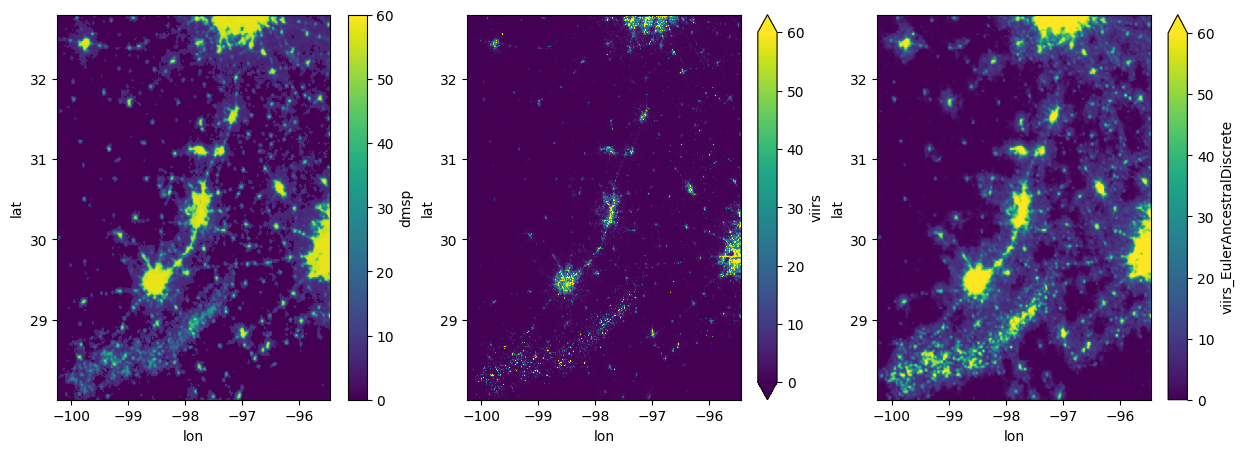

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_EulerAncestralDiscrete.plot(ax=ax[2], vmax=60)

# EulerDiscreteScheduler

In [ ]:
from diffusers import EulerDiscreteScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = EulerDiscreteScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="EulerDiscreteScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 1000

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.506465, Avg Val Loss: 0.253273
Saved best model!
Epoch 1: Avg Train Loss: 0.186042, Avg Val Loss: 0.137666
Saved best model!
Epoch 2: Avg Train Loss: 0.112052, Avg Val Loss: 0.093040
Saved best model!
Epoch 3: Avg Train Loss: 0.082847, Avg Val Loss: 0.074521
Saved best model!
Epoch 4: Avg Train Loss: 0.065067, Avg Val Loss: 0.072211
Saved best model!
Epoch 5: Avg Train Loss: 0.055703, Avg Val Loss: 0.053952
Saved best model!
Epoch 6: Avg Train Loss: 0.052659, Avg Val Loss: 0.043682
Saved best model!
Epoch 7: Avg Train Loss: 0.043132, Avg Val Loss: 0.045813
Early stopping patience: 1/5000
Epoch 8: Avg Train Loss: 0.045487, Avg Val Loss: 0.037929
Saved best model!
Epoch 9: Avg Train Loss: 0.032223, Avg Val Loss: 0.038650
Early stopping patience: 1/5000
Epoch 10: Avg Train Loss: 0.041386, Avg Val Loss: 0.033638
Saved best model!
Epoch 11: Avg Train Loss: 0.039939, Avg Val Loss: 0.038693
Early stopping patience: 1/5000
Epoch 12: Avg Train Loss: 0.033737, Avg Val 

In [ ]:
model.eval()
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/50 [00:00<?, ?it/s]

The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage e

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_EulerDiscreteScheduler': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

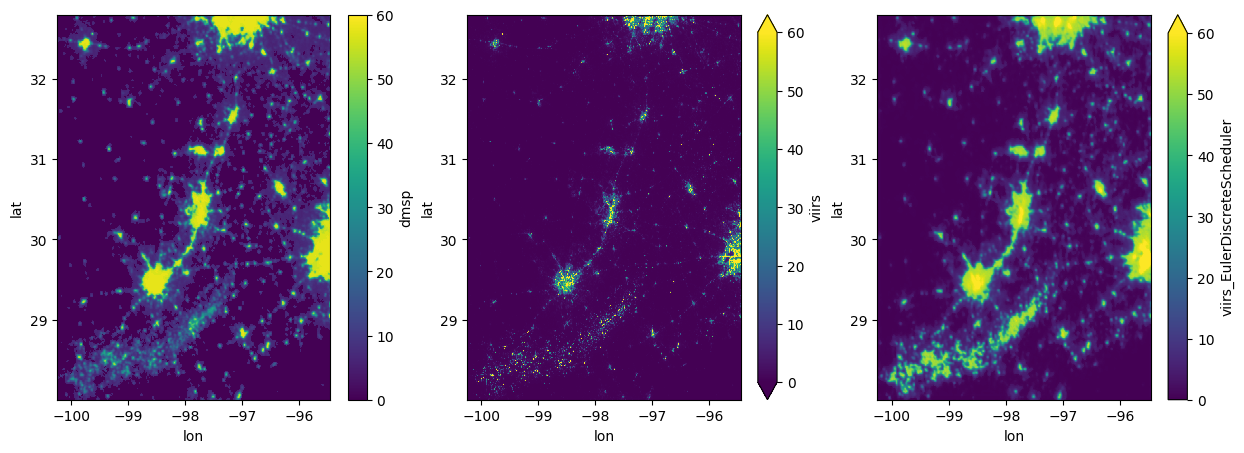

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_EulerDiscreteScheduler.plot(ax=ax[2], vmax=60)

# HeunDiscreteScheduler

In [ ]:
from diffusers import HeunDiscreteScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = HeunDiscreteScheduler()

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="HeunDiscreteScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# How many runs through the data should we do?
n_epochs =5000
n_epochs = 1000

class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.466999, Avg Val Loss: 0.202083
Saved best model!
Epoch 1: Avg Train Loss: 0.152321, Avg Val Loss: 0.102515
Saved best model!
Epoch 2: Avg Train Loss: 0.082243, Avg Val Loss: 0.079475
Saved best model!
Epoch 3: Avg Train Loss: 0.063706, Avg Val Loss: 0.066963
Saved best model!
Epoch 4: Avg Train Loss: 0.052175, Avg Val Loss: 0.057640
Saved best model!
Epoch 5: Avg Train Loss: 0.048251, Avg Val Loss: 0.048647
Saved best model!
Epoch 6: Avg Train Loss: 0.049810, Avg Val Loss: 0.051083
Early stopping patience: 1/5000
Epoch 7: Avg Train Loss: 0.039369, Avg Val Loss: 0.036695
Saved best model!
Epoch 8: Avg Train Loss: 0.033383, Avg Val Loss: 0.039190
Early stopping patience: 1/5000
Epoch 9: Avg Train Loss: 0.030519, Avg Val Loss: 0.033834
Saved best model!
Epoch 10: Avg Train Loss: 0.029125, Avg Val Loss: 0.027671
Saved best model!
Epoch 11: Avg Train Loss: 0.025095, Avg Val Loss: 0.027721
Early stopping patience: 1/5000
Epoch 12: Avg Train Loss: 0.023985, Avg Val 

In [ ]:
model.eval()
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_EulerDiscreteScheduler': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

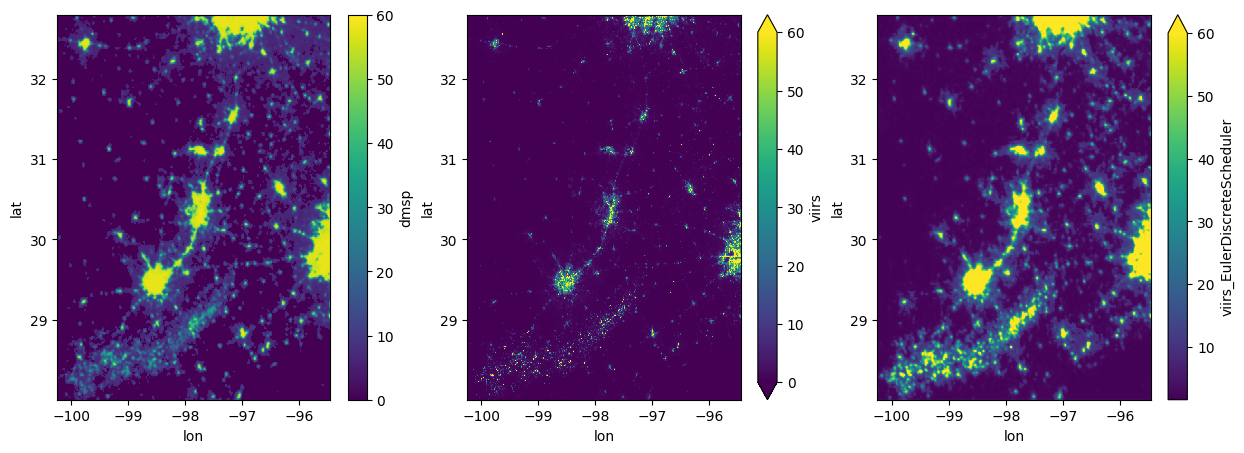

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_EulerDiscreteScheduler.plot(ax=ax[2], vmax=60)